---
# <font color='blue'> Case Study 5 </font>


## <font color='blue'>Group</font>
* Helene Barrera
* Sam Vonpaays Soh
* Justin Ehly

## <font color='blue'>Business Understanding (5pts)</font>
<br>
The purpose of this case is to use an SVM and SGD model to predict the class of internet connections to a corporate firewall using historical connection data. In other words, the model should automatically decide whether to accept or deny internet traffic based on the variables and data provided. The goal of this model is to save the company manpower and resources that could be directed elsewhere. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

In [2]:
# justin's PC directory
#os.chdir('C:\\Users\\justi\\Google Drive\\_SMU\\7333 - Quantifying the World\\Case Study 5')
os.chdir('D:\\MS in Data Science\\Quantifying\\Case Study 5')
os.getcwd()

'D:\\MS in Data Science\\Quantifying\\Case Study 5'

## <font color='blue'>Data Evaluation/ Engineering (10pts)
</font>

### Summary   
The data provided consists of 65,531 observations of internet traffic data including whether each observation was allowed or denied by the company's firewall. There is no missing data in the set. A binary target variable was created from the action column (allow/deny). 

PCA was run along with a K-Means cluster as part of the EDA to determine if the data could be broken down into simpler groups, but the resulting clusters were not clearly defined and thus we decided to move forward without that component. 

All metrics of bytes and packets were highly correlated with each other (over 94%), so all variables pertaining to packets were removed (packets, pkts_sent and pkts_received) to avoid skewing the model. Additionally bytes (which represents sent + received) was highly correlated with bytes_sent (over 90%) and somewhat correlated with bytes_received, which makes sense because it's a metric derived from the other two metrics. Because of the high correlation and its relationship to the other two metrics, bytes was removed as well. 

Lastly, the port columns were examined closely to determine if a rule could be implemented such as "always allow" or "always deny" for certain port combinations. However, most of the ports had less than 30 occurances making any attempt to create rules for that subsection of the data unreliable. Since the remaining data contained less than 1% of the total occurances, it was not practical to further develop rules.  

#### Data clean up

In [3]:
# import the data
web = pd.read_csv('log2.csv')

# knowing that the original data has the first letter capitalized
# make all column headers lower case
cols = pd.Series(web.columns)
cols = cols.str.lower()
# repace spaces with underscores, remove [()] from (sec)
cols.replace(regex=[' ','[()]'], value=['_',''], inplace=True)
web.columns = cols

In [4]:
# no missing values based on the .info report
web.head()

,source_port,destination_port,nat_source_port,nat_destination_port,action,bytes,bytes_sent,bytes_received,packets,elapsed_time_sec,pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [5]:
# create the binary target variable
print(web.action.unique())
web.action = ['deny' if x in ['drop','deny', 'reset-both'] else 'allow' for x in web.action ]
print(web.action.unique())

print('Class distribution for target variable:\n')
print(web.action.value_counts(normalize=True)*100)

['allow' 'drop' 'deny' 'reset-both']
['allow' 'deny']
Class distribution for target variable:

allow    57.437588
deny     42.562412
Name: action, dtype: float64


In [6]:
# create X,y
X = copy.deepcopy(web.drop(columns = ['action']))
y = copy.deepcopy(web.action)


#### PCA and KMeans Exploration

[0.92974676 0.07023119]
[1.78490627e+09 4.90566720e+08]
Location: 			 Class Label


C:\Users\Helene\anaconda3\envs\ML7331\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator KMeans from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Helene\AppData\Local\Temp/ipykernel_35520/4245100250.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(reduced[i][0], reduced[i][1],'k.',


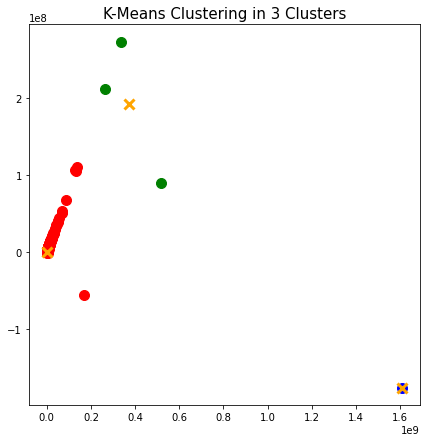

In [7]:
#'''
#use PCA to reduce to 2 vectors
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py


from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
import pickle


def pca_model(X,y):
    # PCA
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(X,y)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)
    pca.get_params()
    return reduced

clusters = 3

def kmean_cluster(reduced, clusters):    
    # KMeans
    kmeans = KMeans(n_clusters=clusters, random_state=42) # set number of clusters
    kmeans.get_params() # just curious what the params are
    kmeans.fit(reduced) # fit kmeans
    return kmeans, clusters

reduced = pca_model(X,y)
#kmeans = kmeans_cluster(reduced)


filename1 = 'kmeans.pickle'
filename2 = 'reduced.pickle'
'''
# write the pickle file
outfile = open(filename1, 'wb')
pickle.dump(kmeans, outfile)
outfile.close()

'''

# load the pickle file
infile = open(filename1, 'rb')
kmeans = pickle.load(infile)
infile.close()


kmeans_group = kmeans.predict(reduced)
labels = kmeans.labels_
    
# plot results
fig, ax = plt.subplots(1,1, figsize=(7,7))
colors = ['red','blue','green']
ax.set_title('K-Means Clustering in %d Clusters' % clusters , size=15)
print('Location:','\t\t\t','Class Label')
for i in range(len(reduced)):
    ax.plot(reduced[i][0], reduced[i][1],'k.', 
            color = colors[labels[i]],
            markersize=20)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=100, linewidths=3,
            color='orange', zorder=10)
plt.show()
#'''
print() # to keep the commented section from printing


In [8]:
clus = pd.DataFrame(kmeans.labels_, columns = ['clusters'])
clus['action'] = copy.deepcopy(web.action)
print(clus.value_counts())
print()
print(clus[(clus.clusters == 1) | (clus.clusters == 2)]['action'])
# the clusting doesn't seem to show much in terms of the actions 

clusters  action
0         allow     37636
          deny      27892
2         allow         3
1         allow         1
dtype: int64

10220    allow
40689    allow
61429    allow
63595    allow
Name: action, dtype: object


The 3 clusters are not very useful in practice since almost all the data is in group 0.

#### Variable Correlation

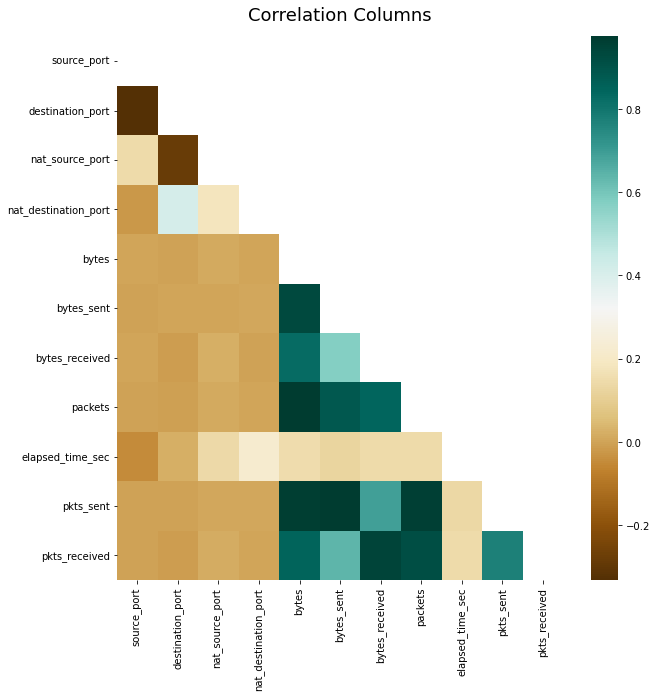

In [9]:
#correlation plot
import seaborn as sns
import matplotlib.pyplot as plt
corr = web.corr()
matrix = np.triu(corr)


f, ax = plt.subplots(figsize=(10,10))
heatmap = sns.heatmap(corr, annot=False, mask=matrix, cmap='BrBG')
heatmap.set_title('Correlation Columns', fontdict={'fontsize':18}, pad=16);
plt.show()

In [10]:
web = web.drop(columns = ['packets', 'pkts_sent', 'pkts_received', 'bytes'])

As explained in the section summary, 'packets', 'pkts_sent', 'pkts_received', and 'bytes' were removed due to collinearity issues. 

#### Ports and Rules

In [11]:
# change port columns to category
web.iloc[:,0:4] = web.iloc[:,0:4].astype('category')

In [12]:
# how many times each unique port number appears in the dataset

def port_counts(data, threshold):
    # data: dataframe
    # threshold: min nummber of times a port should appear in the dataset 
    feature_dist = {}
    
    # establish a threshold for how to split up the minority class of predictors 
    threshold = threshold
    uc = 'unique count'
    for feature in data.iloc[:,0:4]:
        counts = data[feature].value_counts()
        feature_dist[feature] = {uc + ' >= ' + str(threshold): counts[(counts >= threshold)].count(),
                                 uc + ' < ' + str(threshold): counts[(counts < threshold)].count(),}
     
    return feature_dist

def print_port_counts(data, threshold):
    # prints out the port counts
    feature_dist = port_counts(data, threshold)
    print('How often unique port numbers appear in the dataset:')
    print('Threshold: %d' % threshold)
    print('---------------\n')
    
    for key,value in feature_dist.items():
        print(key , ':')
        for i,j in value.items():
            print('  ',i,':', j,'ports')
        print('\n---------------\n')

def assign_port_names(data, threshold):
    # returns just dictionary of the port_names, keys = port_names
    # port_names: dict of lists of the new port names for each port type
    port_names_dict = {}
    
    # establish a threshold for how to split up the minority class of predictors 
    threshold = threshold
    
    for feature in data.iloc[:,0:4]:
        counts = data[feature].value_counts()
        
        # use set comprehension to 
        port_names_dict[feature] = {port if counts[i] >= 30 else 'pooled_port' for i, port in enumerate(counts.index)}

    return port_names_dict

   

In [13]:
#Most of the ports have less than 30 occurances
print_port_counts(web, 30)

How often unique port numbers appear in the dataset:
Threshold: 30
---------------

source_port :
   unique count >= 30 : 35 ports
   unique count < 30 : 22689 ports

---------------

destination_port :
   unique count >= 30 : 83 ports
   unique count < 30 : 3190 ports

---------------

nat_source_port :
   unique count >= 30 : 3 ports
   unique count < 30 : 29149 ports

---------------

nat_destination_port :
   unique count >= 30 : 24 ports
   unique count < 30 : 2509 ports

---------------



<b> A select few ports of each type get the majority of the traffic. It may be possible to create a rule for the more frequent ports.

In [14]:
ports = assign_port_names(web, 30)
port_types = list(ports.keys())
traffic = copy.deepcopy(web) # traffic = firewall traffic

for type in port_types:
    traffic[type] = [port if traffic[type][x] in ports[type] 
                     else 'pooled_port' for x, port in enumerate(traffic[type])]

In [15]:
# create combinations of each port with accept/ deny
import itertools
from itertools import *

port_action = np.array(copy.deepcopy(traffic[['source_port','destination_port',
                                              'nat_source_port','nat_destination_port', 'action']]), str)

# make a list of combinations of ports and the resulting action
def combs(port_action):
    iters = [list(combinations(list(port_action[i]),5)) for i in range(len(port_action))]
    port_comb = [item for sublist in iters for item in sublist]
    return port_comb

# count the number of combinations
def combs_list(port_action):
    port_comb = combs(port_action)
    port_comb = sorted(port_comb)
    comb_counts = {}
    for i in port_comb:
        comb_counts[i] = port_comb.count(i)
    comb_sorted = sorted(comb_counts.items(), key = lambda x:x[0], reverse = True)
    return comb_sorted

combs = combs(port_action)
#comb_sorted = combs_list(port_action)




In [16]:
#pickle results of last cell
import pickle

filename = 'port_combinations_sorted.pickle'
'''# write the pickle file
outfile = open(filename, 'wb')
pickle.dump(comb_sorted, outfile)
outfile.close()
'''

# load the pickle file
infile = open(filename, 'rb')
comb_sorted = pickle.load(infile)
infile.close()

In [17]:
# resort because the pickled file was sorted by the number of occurences and not by the order of the combination
comb_sorted = sorted(comb_sorted, key = lambda x:x[0], reverse = True)

# explore the combinations of ports used more than 30x to see if there are any that are always allow or deny
combination_rules = [x for x in comb_sorted if ('pooled_port' not in x[0]) and (x[1] >= 30)]
combination_rules = combination_rules[0:9]
#combination_rules
# any time we have these combinations of ports we know how to automatically set the action without the need to model

# just remove the 4 combination sets
comb_to_match = [x[0][0:4] for x in combination_rules]

In [18]:
combination_rules

[(('6881', '6881', '0', '0', 'deny'), 32),
 (('58638', '5900', '58638', '5900', 'allow'), 50),
 (('58638', '5900', '0', '0', 'deny'), 789),
 (('5588', '5588', '0', '0', 'allow'), 87),
 (('48706', '23393', '0', '0', 'deny'), 44),
 (('45941', '23386', '0', '0', 'deny'), 53),
 (('3478', '61463', '0', '0', 'deny'), 104),
 (('19875', '30170', '0', '0', 'deny'), 31),
 (('13285', '29892', '0', '0', 'deny'), 30)]

As stated in the summary section, very few of the ports have enough observations (1k out of 65k) to create any sort of rule, therefore we will continue without forming rules. 

## <font color='blue'>Modeling Preparations (10pts)</font>
   
- <b>Which methods are you proposing to utilize to solve the problem?</b><br>
We will build a Support Vector Machine (SVM) assisted by the use of Stochastic Gradient Descent (SGD). The purpose of SVM is to draw a line/hyperplane between classes with as much separation as possible, while SGD is an optimization function that can help us converge on the best model more efficiently. Due to the way it runs (training on every data point), SVM is not ideal for large datasets as it is computationally expensive. Using SGD allows us to still get the benefits of SVM, but in a way that scales for large data sets. By running SGD classifier with a hinge loss, we are using the efficiency of SGD to find the best hyperplane quickly. 
   
   
- <b>Why is this method important based on the business objective?</b><br>
It is important for the business to be able to run the model quickly and frequently because of the constant and massive amount of incoming data. Additionally, the accuracy should be comparable to what a SVM would produce. 
   
   
- <b>How will we determine if this approach is useful? </b><br>
The approach will be the most useful if it can reduce or preferably eliminate bad ports being allowed through the firewall. A secondary goal would be to minimize the number of good ports that are blocked by the firewall. 
   
   
- <b>What evaluation metrics are most useful or requested by the client and do you have any suggestions on additional metrics to consider? (Acc, Recall, Prec, F-1 Score, ROC, AUC, etc)</b><br>
The client specified accuracy as their primary interest, but number of false positives will also be important since the consequences of allowing a bad port though could be high. Additionally the client desired a fast and efficient model, so the time it takes to run will be taken into account. 

## <font color='blue'> Model Building & Evaluation (60pts)</font>
In this case, the primary task is to use SVM and SGD to build a model to determine whether or not to accept or deny access to internet requests coming across a network and will involve the following steps:      

   
-<b> Specify sampling methodology</b>   
We will use an 80/20 stratified shuffle split with 5 folds that are used for cross validation later. 
<br><br>       

-<b> Setup models</b>    
For our basic SVC model, the most important parameters are the kernal and C. For the kernal, we basically just needed to specify the type of kernal to use which in this case we chose Linear. C represents the trade-off between having a wide margin between the classes and potentially misclassifying something due to that wide margin. (Or conversely a small margin which doesn't differentiate the classes particularly well. 

For our SVM with SGD, there are a lot more parameters to adjust (which could be a pro or con depending on the user and situation). The most important parameter here is the loss funtion, which must be set to hinge in order to run like a SVM. The hinge loss function will maximize the distance between classes, just like the SVM. The penalty and alpha work together as a regularization term to ensure the model doesn't overfit. Typically an l2 penalty is applied and the alpha is adjusted in smaller increments. l1_ratio must be set to 0 for an l2 penalty but the default is .15 so this must be done manually. Most other parameters such as fit_intercept, learning_rate, and n_jobs are functional as their default settings but could be adjusted in specific scenarios.
<br><br>

-<b> Analyze the models' performance</b>     
Both models were highly accurate (99.8% for the SVC and 99.6% for the SGD). However, the SVC took 39.6 seconds to run, while the SGD took only .12 seconds. In other words, the SVC took 330 times as long to run as the SGD model, while only granting a .2% improvement on accuracy. Looking at false positives, the both models performed practically the same - the SGD allowing 18 bad ports past the firewall compared to the 17 of the SVM model. Out of 65k total observations, those numbers are tiny. For the massive increase in efficiancy which will allow for scalability with very little trade-off of accuracy and false positives, the SGV is the clear winner here. 

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)

def sss(X,y): 
    for train_idx, test_idx in cv.split(X,y):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    return X_train, X_test, y_train, y_test


def scaler(X_train, X_test):
    # scale int data
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)
    return X_train, X_test

def encoder(y_train, y_test):
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoder.transform(y_train)
    encoder.transform(y_test)
    return y_train, y_test

In [20]:
#split the data
# create X,y
X = copy.deepcopy(web.drop(columns = ['action']))
y = copy.deepcopy(web.action)

X_train, X_test, y_train, y_test = sss(X, y) # Strat_Shuffle_Split
X_train, X_test = scaler(X_train, X_test) # standardScaler

print(X_train.shape, X_test.shape)

(52425, 7) (13107, 7)


### SVC MODEL

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# run the model as linear to get best features
start = time.time()
svc_model = SVC(C=1, kernel='linear', random_state = 42).fit(X_train, y_train)
stop = time.time()

svc_predictions = svc_model.predict(X_test)
svc_acc = accuracy_score(y_test, svc_predictions)


print('SVC Model')
print('Accuracy:', svc_acc)   
print(f"Training Time: {stop-start}")
print()
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, svc_predictions, labels=['allow', 'deny']),
            columns=['allow', 'deny'],
            index=['allow', 'deny']))

SVC Model
Accuracy: 0.9983978027008469
Training Time: 40.01999759674072

Confusion Matrix:
       allow  deny
allow   7511    17
deny       4  5575


### SVM MODEL WITH SGD

In [22]:
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5


start = time.time()
svm_sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.1,
        fit_intercept=True, l1_ratio=0.0, random_state = 42)
svm_sgd.fit(X_train,y_train)
stop = time.time()


y_hat = svm_sgd.predict(X_test)  
acc = accuracy_score(y_test,y_hat)

print('SVM with SGD')
print('Accuracy:', acc)
print(f"Training Time: {stop-start}")
print()
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_hat, labels=['allow', 'deny']),
            columns=['allow', 'deny'],
            index=['allow', 'deny']))

SVM with SGD
Accuracy: 0.9961852445258259
Training Time: 0.12602829933166504

Confusion Matrix:
       allow  deny
allow   7510    18
deny      32  5547


#### ROC CURVE

In [30]:
le = LabelEncoder().fit(y_test)
y_test_bi = le.transform(y_test)

le = LabelEncoder().fit(y_test)
y_hat_bi = label_encoder.transform(y_hat)

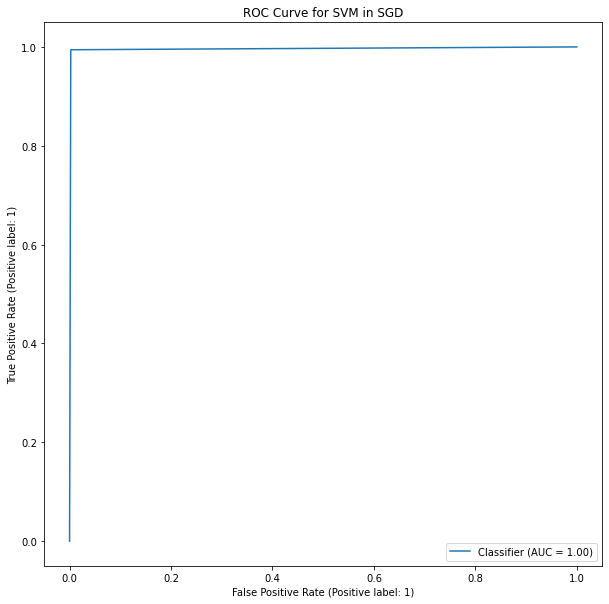

In [31]:
#the metrics are all showing as 1 due to high performance
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(1,1,figsize=(10,10))

RocCurveDisplay.from_predictions(y_test_bi, y_hat_bi, ax=ax)
ax.set_title('ROC Curve for SVM in SGD')
plt.show() 

## <font color='blue'>Case Conclusions (10pts)</font>
- <b>After all of your technical analysis and modeling; what are you proposing to your audience and why?</b>   
Because both models are highly accurate and SGD runs over 300 times faster than SVC with almost no trade-offs, it's clear the management should implement the SGV model. It runs quickly, it's easy to adjust and fine tune parameters to quickly react to new data. It's highly scalable and not resource intensive.  <br><br>

- <b>How should they view your results and what should they consider when moving forward?</b>  
These results are very conclusive and accurate. There is room for improvement but the gains vs the amount of resources expended would see diminishing returns.  <br><br>
  
- <b>Are there other approaches you'd recommend exploring?</b>  
If the management is set on having 0 errors when it comes to allowing bad ports through the firewall, there are avenues that could be explored. A GridSearch could be used that chooses the optimal parameters based on minimizing false positives. Additionally, the rules avenue could be pursued further - although it would be time consuming, it could possibly help to reduce those last few false positives. <br><br>

- <b>This is where you "bring it all home" in language they understand.</b>   
It's not every day a model has such high metrics and runs so quickly. Management should definitely jump on this opportunity to boost the speed and efficiancy of their company. 

